In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

In [ ]:
! apt-get update
! apt-get install -y fonts-nanum
! fc-cache -fv
! rm -rf ~/.cache/matplotlib/*

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
%cd /workspace/

/workspace


## 음극 인장강도 Regression

In [4]:
# import excel file sheet

df = pd.read_csv('/workspace/data/processed/음극/rule_based_final.csv')

# Data Pre-processing: Use data up to row 38
data_selected = df.copy()

# Define features and target 
features = data_selected.drop(columns=["Unnamed: 0", "인장강도"])

target = data_selected["인장강도"]

In [5]:
features.columns

Index(['lo_height_mean_mean', 'lo_height_min_mean', 'lo_height_peak_mean',
       'lo_height_std_mean', 'lo_fwhm_mean', 'lo_area_mean', 'br_peak_mean',
       'br_peak_time_mean', 'br_diff_peak_mean', 'nir_peak_mean',
       'nir_reach_time_mean', 'nir_over_area_mean', 'nir_extra_time_mean',
       'nir_extra_area_mean', 'nir_sum_area_mean', 'vis_peak_mean',
       'vis_reach_time_mean', 'vis_over_area_mean', 'vis_extra_time_mean',
       'vis_extra_area_mean', 'lo_height_mean_std', 'lo_height_min_std',
       'lo_height_peak_std', 'lo_height_std_std', 'lo_fwhm_std', 'lo_area_std',
       'br_peak_std', 'br_peak_time_std', 'br_diff_peak_std', 'nir_peak_std',
       'nir_reach_time_std', 'nir_over_area_std', 'nir_extra_time_std',
       'nir_extra_area_std', 'nir_sum_area_std', 'vis_peak_std',
       'vis_reach_time_std', 'vis_over_area_std', 'vis_extra_time_std',
       'vis_extra_area_std'],
      dtype='object')

In [6]:
features.tail(5) #  마지막 시편 기록에서 s.BR9.5over_길이_MEAN의 값이 0을 기록하고 있는데, 결측치를 일괄 처리한 것인지 아니면 실제 feature가 0인지 확인 필요

,lo_height_mean_mean,lo_height_min_mean,lo_height_peak_mean,lo_height_std_mean,lo_fwhm_mean,lo_area_mean,br_peak_mean,br_peak_time_mean,br_diff_peak_mean,nir_peak_mean,...,nir_reach_time_std,nir_over_area_std,nir_extra_time_std,nir_extra_area_std,nir_sum_area_std,vis_peak_std,vis_reach_time_std,vis_over_area_std,vis_extra_time_std,vis_extra_area_std
10,3.459100,2.503207,3.530270,0.111775,150.037037,344.536887,9.703628,56.759259,9.343146,0.100019,...,30.823566,0.0,5.813989,0.0,1.114523,0.036245,21.796548,0.0,6.595219,0.0
11,3.449690,2.338055,3.529629,0.154565,150.611111,344.388540,9.703831,57.037037,9.375838,0.091144,...,28.143402,0.0,5.170250,0.0,1.086482,0.017063,19.488601,0.0,6.073509,0.0
12,3.904266,3.028436,3.975099,0.107338,150.740741,389.287481,9.701563,48.685185,9.489348,0.130038,...,11.866022,0.0,3.055050,0.0,1.405525,0.015296,11.097105,0.0,1.181127,0.0
13,3.889122,2.636667,3.971521,0.171655,151.000000,389.396880,9.612343,45.555556,9.430264,0.175215,...,20.582265,0.0,11.642774,0.0,2.973667,0.094924,13.635378,0.0,5.589679,0.0
14,3.888451,2.462061,3.970570,0.179950,150.944444,389.116986,9.697656,44.814815,9.511717,0.156236,...,17.622781,0.0,9.867938,0.0,2.191588,0.036762,9.929259,0.0,5.917268,0.0


In [7]:
sum(features.isna().sum()>0) # 결측치 확인 -> 결측치 없음.

0

In [8]:
target.isna().sum() # 결측치 확인 -> 결측치 없음.

0

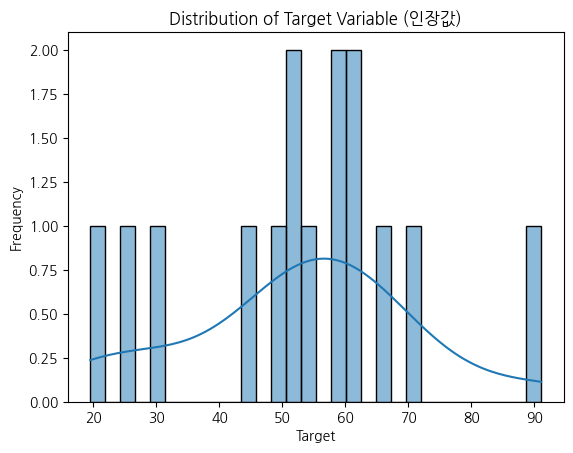

In [9]:
# EDA: Visualizations
# Histogram of the target variable
sns.histplot(target, bins=30, kde=True)
plt.title('Distribution of Target Variable (인장값)')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

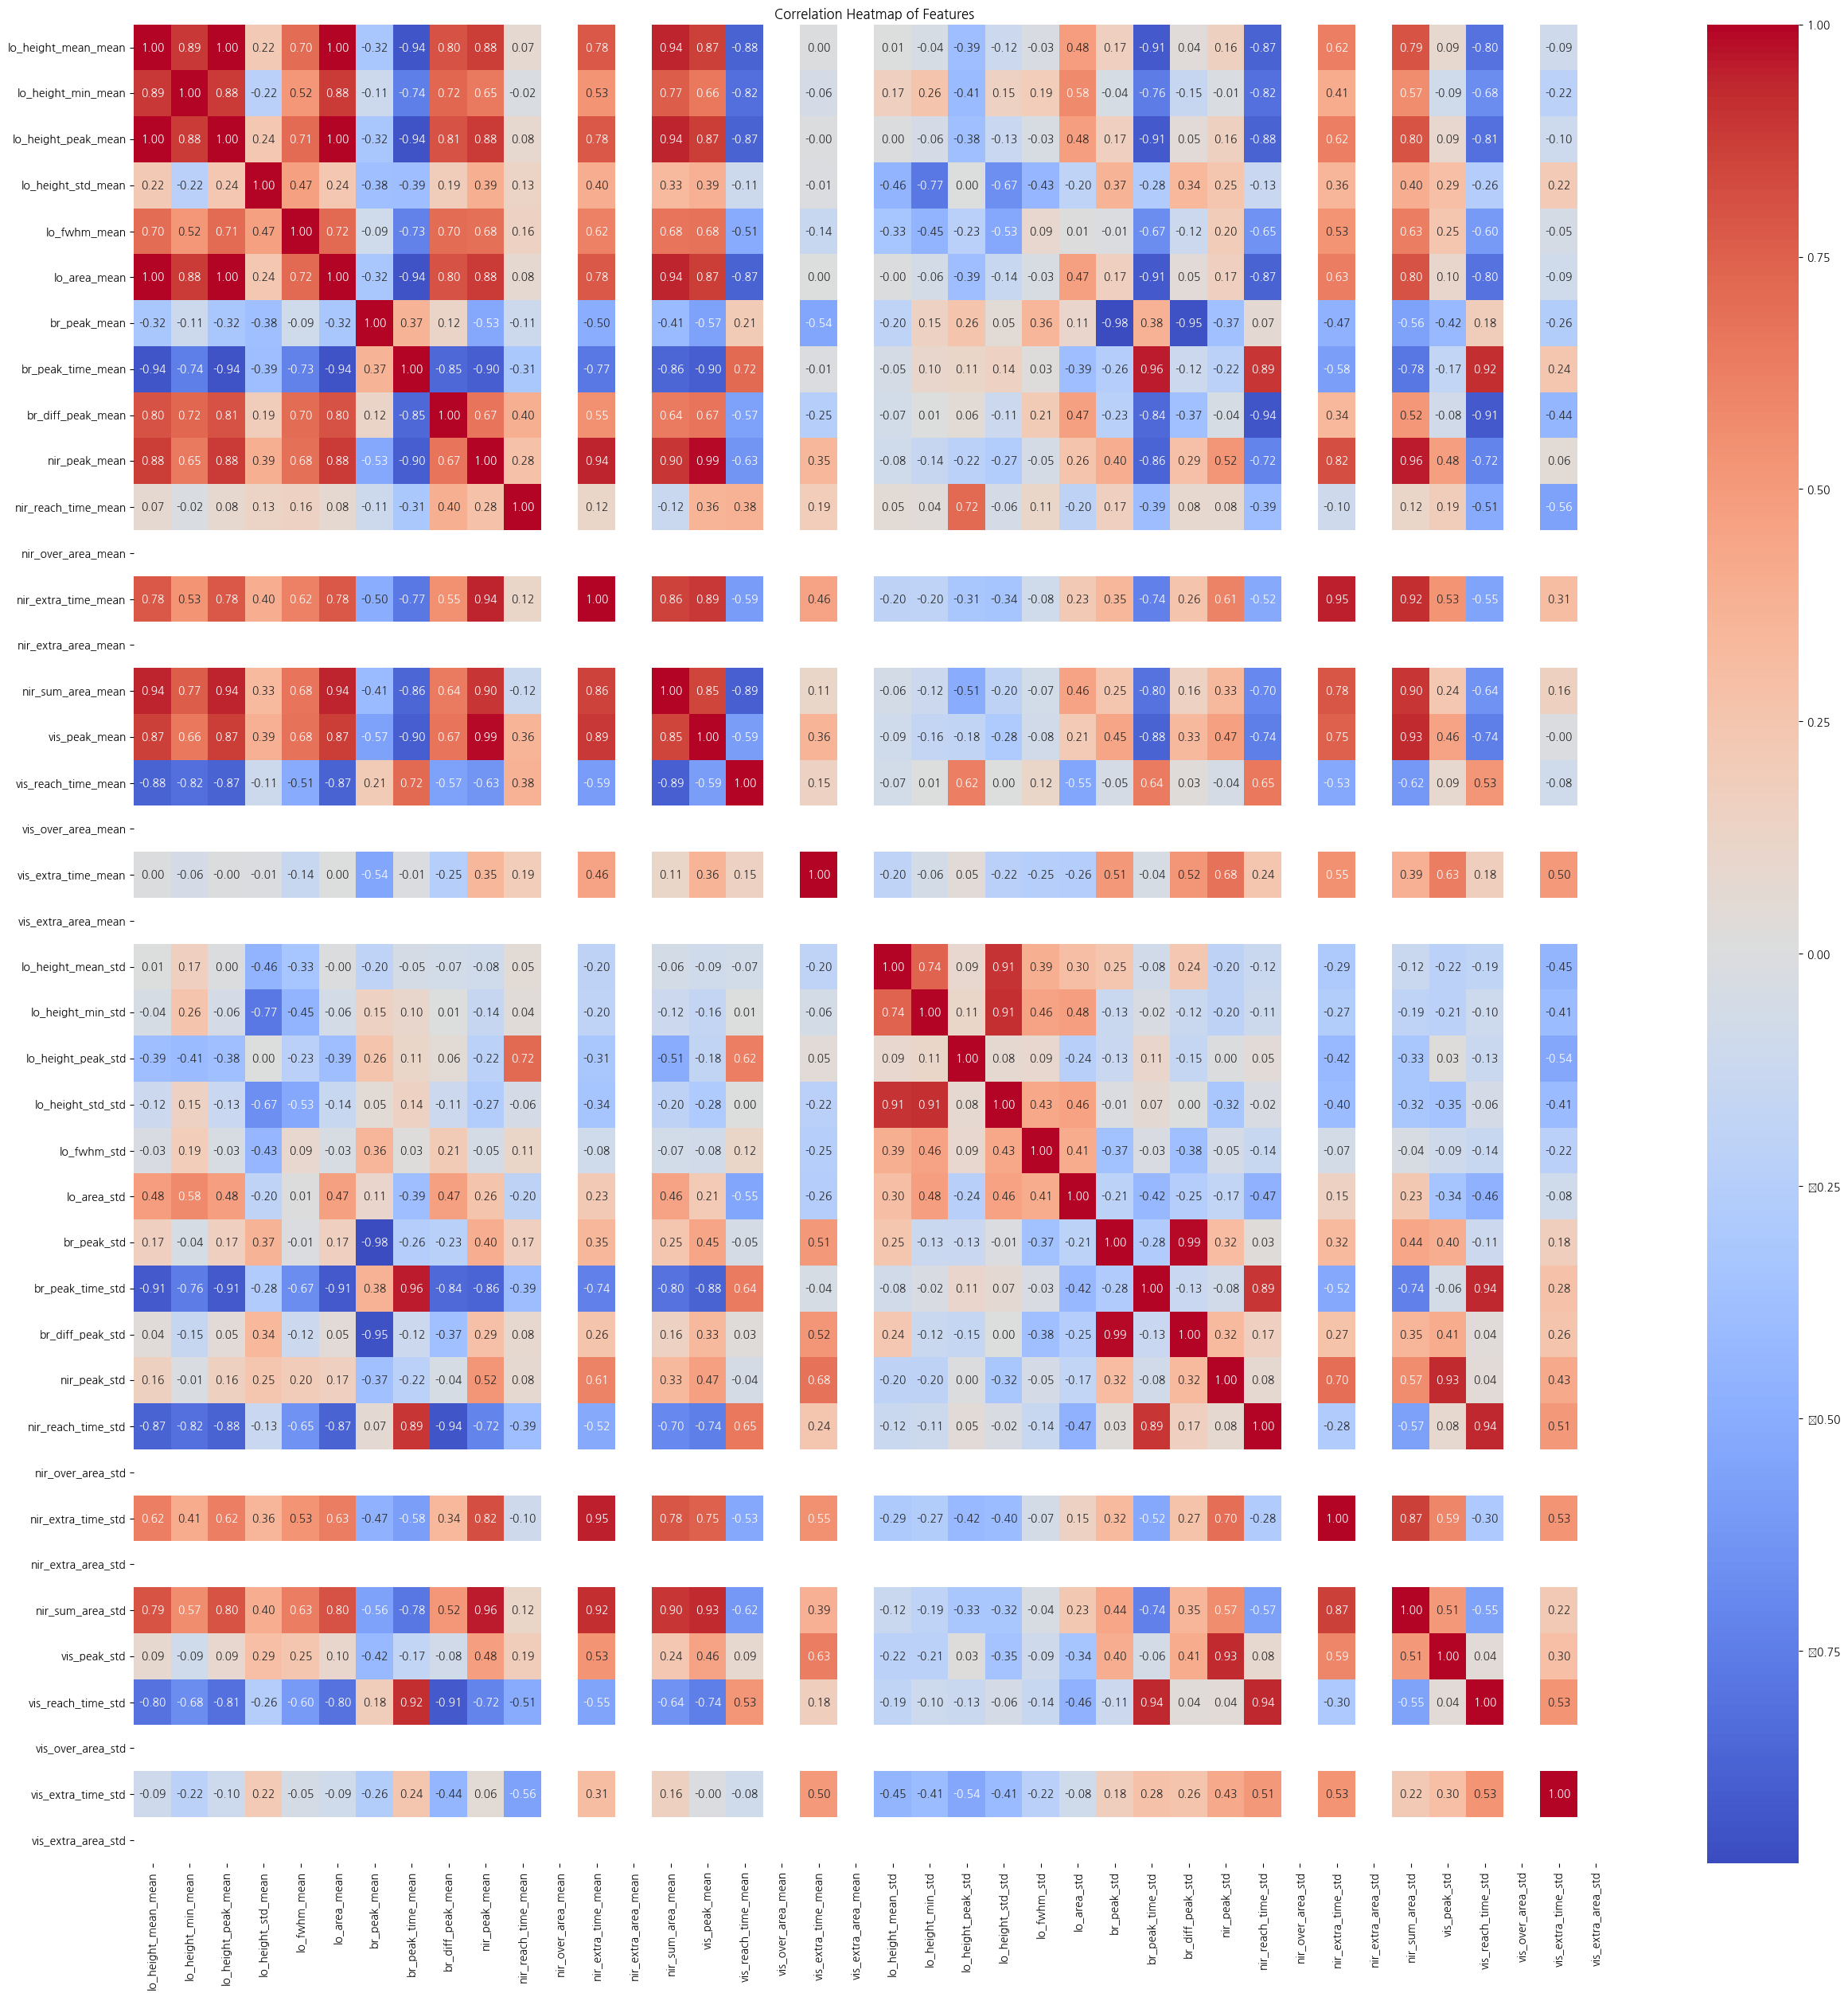

In [10]:
# Correlation heatmap of features 

plt.figure(figsize=(30, 30))
sns.heatmap(features.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [11]:
np.random.seed(42)

# Modeling with LOOCV
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective ='reg:squarederror', random_state=42,
                            tree_method='gpu_hist', 
                            gpu_id=0,
                            ),
    'LightGBM': LGBMRegressor(
                        min_data_in_leaf=1, 
                        min_split_gain=0.0, 
                        num_leaves=31, 
                        max_depth=-1,
                        lambda_l1=0.0,
                        lambda_l2=0.0,
                        learning_rate=0.05,
                        n_estimators=500,
                        random_state=42,
                        device='cpu',
                        verbose=-1
                        )
}

loocv = LeaveOneOut()

results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE'])

In [12]:
from collections import defaultdict
from tqdm import tqdm
feat_import = defaultdict(list)
 
for model_name, model in models.items():
    mse_values = []
    rmse_values = []
    mape_values = []
    mae_values = []
    
    predictions = []
    actuals = []
    
    for train_index, test_index in tqdm(loocv.split(features)):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Normalize data
        scaler = StandardScaler().fit(X_train)  # Compute mean and std on training data
        X_train_scaled = scaler.transform(X_train)  # Scale training data
        X_test_scaled = scaler.transform(X_test)  # Scale test data using training parameters
        
        # Train model
        model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        prediction = model.predict(X_test_scaled.reshape(1,-1))
        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - prediction) / y_test)) * 100
        mae = np.mean(np.abs(y_test - prediction))

        mse_values.append(mse)
        rmse_values.append(rmse)
        mape_values.append(mape)
        mae_values.append(mae)

    try:
        # Extract feature importances
        importances = model.feature_importances_
        
        # Create a DataFrame for visualization
        feature_importances = pd.DataFrame({
            'Feature': features.columns,
            'Importance': importances
        })
        
        # Sort features according to importance
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        feat_import[model_name] = feature_importances

    except AttributeError:
        print(f"{model_name} does not support feature_importances_")

    agg_mse = np.mean(mse_values)
    agg_rmse = np.mean(rmse_values)
    agg_mape = np.mean(mape_values)
    agg_mae = np.mean(mae_values)

    results = results.append({
        'Model': model_name,
        'MSE': agg_mse,
        'RMSE': agg_rmse,
        'MAPE' : agg_mape,
        'MAE' : agg_mae
    }, ignore_index=True)

    print(f"{model_name} - MSE: {agg_mse:.2f}, RMSE: {agg_rmse:.2f}, MAPE: {agg_mape:.2f}, MAE: {agg_mae:.2f}")

15it [00:00, 161.28it/s]


Linear Regression does not support feature_importances_
Linear Regression - MSE: 116.93, RMSE: 9.14, MAPE: 18.73, MAE: 9.14


15it [00:00, 195.84it/s]


Ridge Regression does not support feature_importances_
Ridge Regression - MSE: 134.94, RMSE: 9.48, MAPE: 17.92, MAE: 9.48


15it [00:00, 172.54it/s]


Lasso Regression does not support feature_importances_
Lasso Regression - MSE: 65.25, RMSE: 6.63, MAPE: 12.95, MAE: 6.63


15it [00:00, 39.07it/s]


Gradient Boosting - MSE: 123.35, RMSE: 9.00, MAPE: 17.64, MAE: 9.00


15it [00:03,  4.52it/s]


XGBoost - MSE: 149.95, RMSE: 9.62, MAPE: 18.60, MAE: 9.62


15it [00:01,  9.87it/s]

LightGBM - MSE: 118.69, RMSE: 8.69, MAPE: 17.89, MAE: 8.69


In [13]:
results

,Model,MSE,RMSE,MAPE,MAE
0,Linear Regression,116.932130,9.137544,18.732989,9.137544
1,Ridge Regression,134.940459,9.478163,17.921888,9.478163
2,Lasso Regression,65.251590,6.632006,12.950206,6.632006
3,Gradient Boosting,123.348571,9.002976,17.644949,9.002976
4,XGBoost,149.949678,9.621508,18.604985,9.621508
5,LightGBM,118.693292,8.686805,17.889359,8.686805


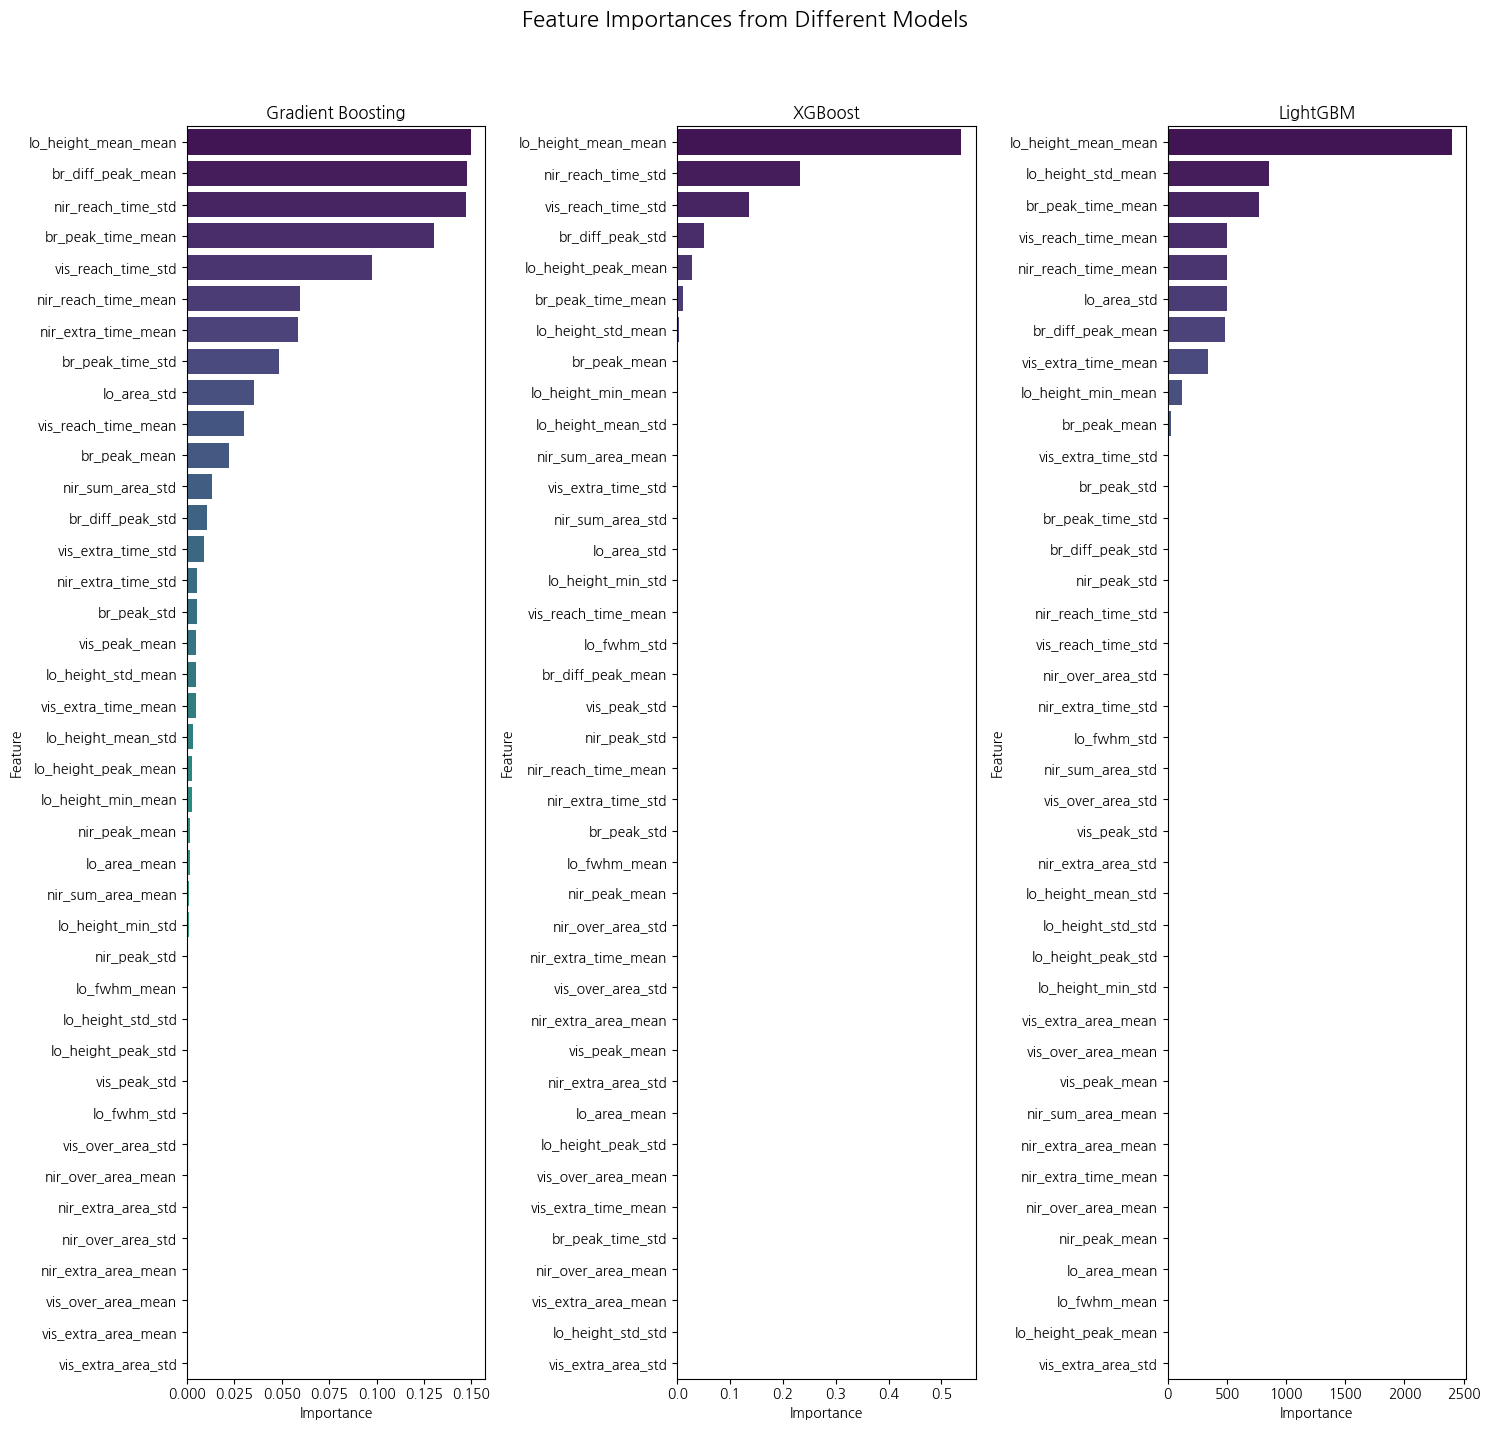

In [15]:
model_import = ['Gradient Boosting', 'XGBoost', 'LightGBM']

# Set up the matplotlib figure
num_models = len(model_import)
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 15))
fig.suptitle('Feature Importances from Different Models', fontsize=16)

# Plotting
for ax, model_name in zip(axes, model_import):

    feature_importances = feat_import[model_name]
    
    # Plot
    sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax, palette='viridis')
    ax.set_title(model_name)
    ax.set_xlabel('Importance')
    
axes[0].set_ylabel('Feature')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()

In [18]:
features_best = data_selected[feat_import['Gradient Boosting']['Feature'][:5]]
feat_import_best = defaultdict(list)


mse_values = []
rmse_values = []
predictions = []
actuals = []

model_name = 'Gradient Boosting'
model = models[model_name]

for train_index, test_index in loocv.split(features_best):
    X_train, X_test = features_best.iloc[train_index], features_best.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Normalize data
    scaler = StandardScaler().fit(X_train)  # Compute mean and std on training data
    X_train_scaled = scaler.transform(X_train)  # Scale training data
    X_test_scaled = scaler.transform(X_test)  # Scale test data using training parameters
    
    # Train model
    model.fit(X_train_scaled, y_train)

    # Predict and evaluate
    prediction = model.predict(X_test_scaled.reshape(1,-1))
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)

    mse_values.append(mse)
    rmse_values.append(rmse)
    
    agg_mse = np.mean(mse_values)
    agg_rmse = np.mean(rmse_values)

print(f"{model_name} - MSE: {agg_mse:.2f}, RMSE: {agg_rmse:.2f}")


Gradient Boosting - MSE: 115.41, RMSE: 115.41
